In [1]:
import glob
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
import time
import warnings
import cv2

In [2]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [3]:
# def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLinear):
#     transformed_channels = []
#     r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
#     r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
#     for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
#         moving_img_itk = get_itk_from_pil(moving_img)
#         fixed_img_itk = get_itk_from_pil(fixed_img)
#         transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
#                             interpolator, 0.0, moving_img_itk.GetPixelID())
#         transformed_channels.append(get_pil_from_itk(transformed_img))
#     rgb_transformed = Image.merge('RGB', transformed_channels)
#     return rgb_transformed
def get_itk_from_pil(pil_img):
    """Converts Pillow image into ITK image
    """
    return sitk.GetImageFromArray(np.array(pil_img))

def get_pil_from_itk(itk_img):
    """Converts ITK image into Pillow Image
    """
    return Image.fromarray(sitk.GetArrayFromImage(itk_img).astype(np.uint8))

def show_alignment(fixed_img, moving_img, prefilter = None):
    """Visualises alignment of fixed image with moving image
    
    Fixed image is displayed as blue
    Moving image is displayed as pink 
    """
    if prefilter == 'TP53':
        tp53_filtered = filter_green(moving_img)
        tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
        moving_img = filter_otsu_global(tp53_filtered, 'PIL')
        he_filtered = filter_green(fixed_img)
        he_filtered = filter_grays(he_filtered, tolerance = 15)
        fixed_img = filter_otsu_global(he_filtered, 'PIL')
    background = (255,255,255)
    img_red = ImageOps.colorize(moving_img.convert('L'), (255, 0, 0), background)
    img_blue = ImageOps.colorize(fixed_img.convert('L'), (0, 0, 255), background)
    img_red.putalpha(120)
    img_blue.putalpha(70)
    return Image.alpha_composite(img_red, img_blue)

def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLanczosWindowedSinc):
    """Applies a Simple ITK transform (e.g. Affine, B-spline) to an RGB image
    
    The transform is applied to each channel
    
    Parameters
    ----------
    moving_rgb_img : Pillow Image 
        This image will be transformed to produce the output image
    fixed_rgb_img : Pillow Image
        This reference image provides the output information (spacing, size, and direction) of the output image
    transform : SimpleITK transform
        Generated from image registration
    interpolator : SimpleITK interpolator
    
    Returns
    -------
    rgb_transformed : Pillow Image
        Transformed moving image 
    """
    transformed_channels = []
    r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
    r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
    for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
        moving_img_itk = get_itk_from_pil(moving_img)
        fixed_img_itk = get_itk_from_pil(fixed_img)
        transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
                            interpolator, 0.0, moving_img_itk.GetPixelID())
        transformed_channels.append(get_pil_from_itk(transformed_img))
    rgb_transformed = Image.merge('RGB', transformed_channels)
    return rgb_transformed    

def start_plot():
    """Setup data for plotting
    
    Invoked when StartEvent happens at the beginning of registration.
    """
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

def end_plot():
    """Cleanup the data and figures 
    """
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def update_plot(registration_method):
    """Plot metric value after each registration iteration
    
    Invoked when IterationEvent happens.
    """
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Metric', fontsize=12)
    plt.show()
    
def update_multires_iterations():
    """Update the index in the metric values list that corresponds to a change in registration resolution
    
    Invoked when the sitkMultiResolutionIterationEvent happens.
    """
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def plot_metric(title = 'Plot of registration metric vs iterations'):
    """Plots the mutual information over registration iterations
    
    Parameters
    ----------
    title : str
    
    Returns
    -------
    fig : matplotlib figure
    """
    global metric_values, multires_iterations
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Iteration Number', fontsize=12)
    ax.set_ylabel('Mutual Information Cost', fontsize=12)
    ax.plot(metric_values, 'r')
    ax.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*', label = 'change in resolution')
    ax.legend()
    return fig

################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')

def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [4]:
def get_files_in_directory(directory, postfix=""):
    fileNames = [s for s in os.listdir(directory) if not os.path.isdir(os.path.join(directory, s))]
    if not postfix or postfix == "":
        return sorted(fileNames)
    else:
        return sorted([s for s in fileNames if s.lower().endswith(postfix)])
    
def get_subdirectories_in_directory(directory, postfix=""):
    dir_names = [s for s in os.listdir(directory) if os.path.isdir(os.path.join(directory, s))]
    return sorted(dir_names)

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)

In [5]:
material_path = '/QRISdata/Q1851/Minh/RNAScope'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')

In [6]:
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
img_dapi2 = cv2.cvtColor(cv2.imread(dapi_2), cv2.COLOR_BGR2RGB)

In [7]:
pil_img_dapi1 = Image.fromarray(img_dapi1)
pil_img_dapi2 = Image.fromarray(img_dapi2)

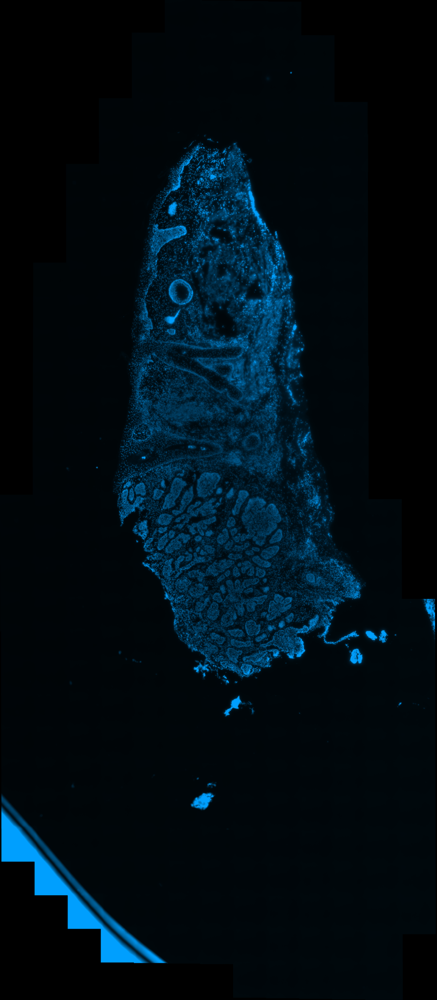

In [8]:
thumbnail(pil_img_dapi1)

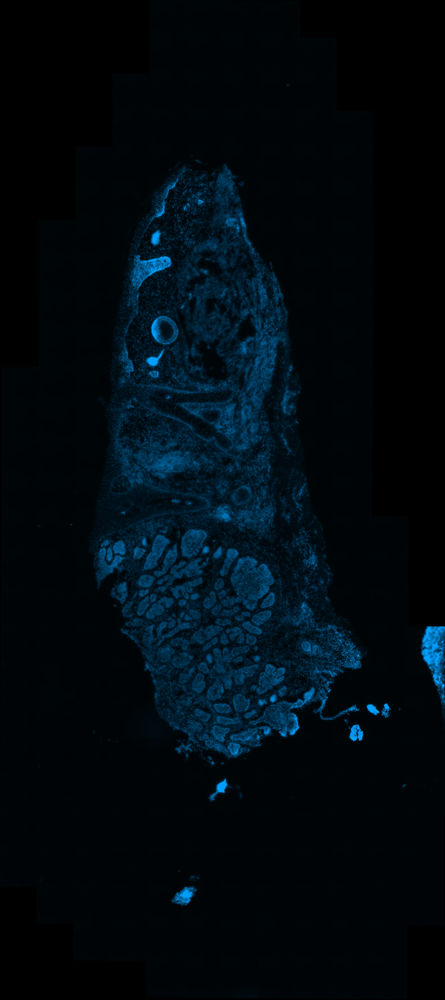

In [9]:
thumbnail(pil_img_dapi2)

In [10]:

dapi1_gray = pil_img_dapi1.convert('L')
dapi2_gray = pil_img_dapi2.convert('L')
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)
dapi2_gray_itk = get_itk_from_pil(dapi2_gray)
fixed_img = dapi1_gray_itk
moving_img = dapi2_gray_itk

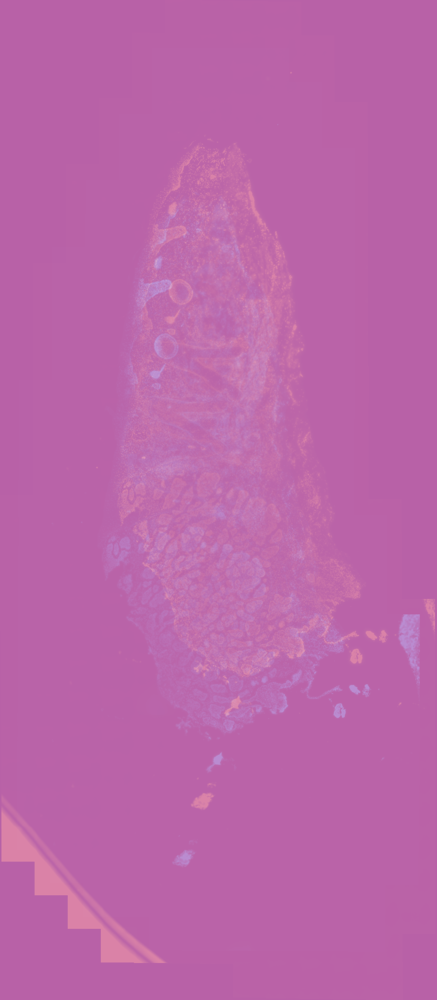

In [11]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())

moving_rgb = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, initial_transform)
thumbnail(show_alignment(pil_img_dapi1, moving_rgb, prefilter = True))

In [21]:
??sitk.CenteredTransformInitializer

In [12]:
################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays 
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')
    
def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [13]:

calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled)))

0.20768385732963932

In [29]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def overlay_pil_imgs(foreground, background, best_loc = (0,0), alpha=0.5):
    newimg1 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg1.paste(foreground, best_loc)
    newimg1.paste(background, (0, 0))

    newimg2 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg2.paste(background, (0, 0))
    newimg2.paste(foreground, best_loc)
    result = Image.blend(newimg1, newimg2, alpha=alpha)
    return result


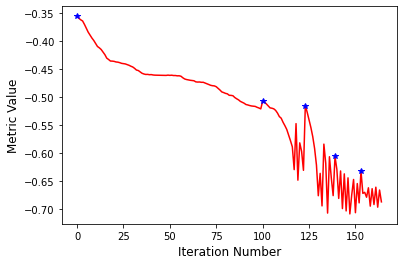

Final metric value: -0.6599007707027372
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 12.


In [40]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.15)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

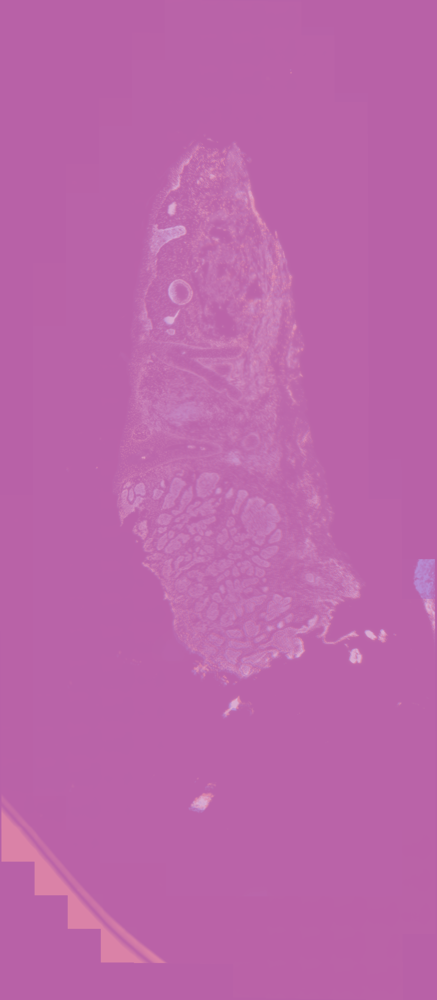

In [46]:
moving_rgb_final = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, final_transform)
thumbnail(show_alignment(pil_img_dapi1, moving_rgb_final, prefilter = True))

In [47]:
moving_resampled = sitk.Resample(moving_img, fixed_img, final_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled)))

0.4482061511632164

In [48]:
pil_img_dapi1.size

(7859, 17989)

In [49]:
register_dapi2_1 = get_pil_from_itk(moving_resampled)
register_dapi2_1.size

(7859, 17989)

In [50]:
print(moving_rgb_final.size)
change_color_mv_rgb_final = np.array(moving_rgb_final)
print(change_color_mv_rgb_final.shape)
foreground = Image.fromarray(cv2.cvtColor(change_color_mv_rgb_final, cv2.COLOR_BGR2RGB))
background = pil_img_dapi1


(7859, 17989)
(17989, 7859, 3)


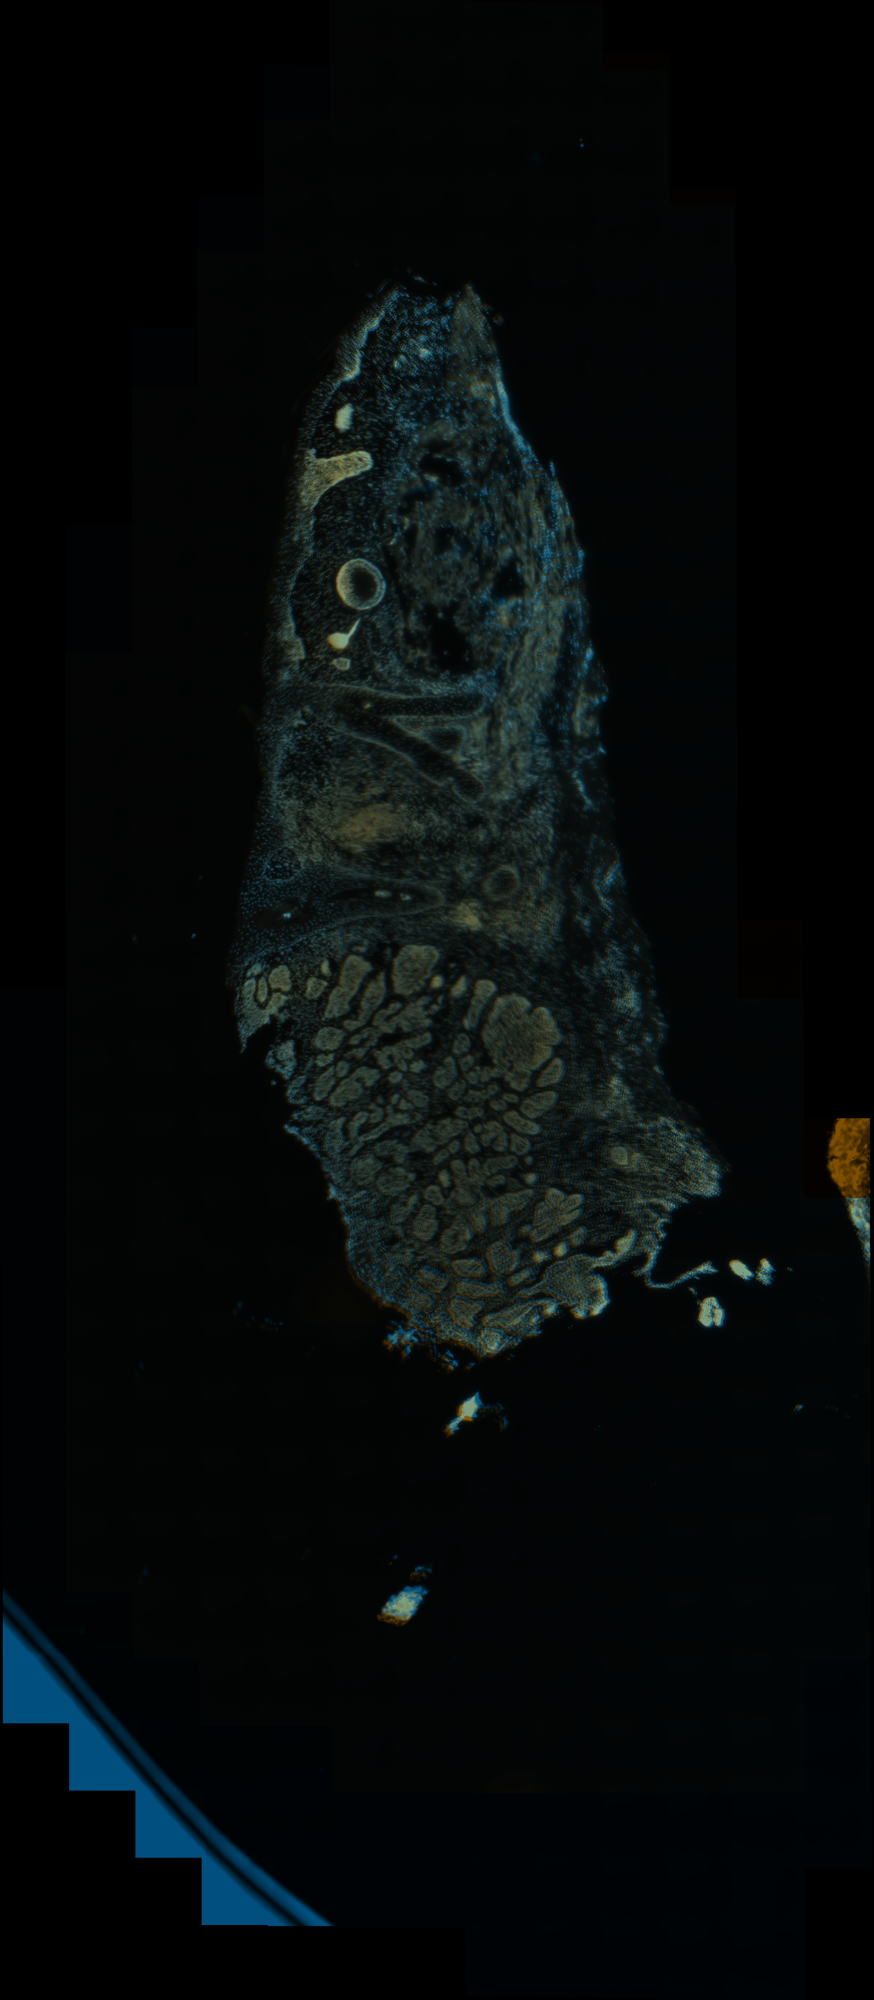

In [51]:
overlayed_imgs_1 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_1, size = (2000,2000))

In [33]:
overlayed_imgs_1=overlayed_imgs_1.convert('RGB')
overlayed_imgs_1.save('sitk_register_1.pdf')

### B-Spline registration


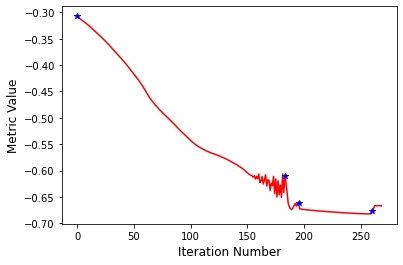

Final metric value: -0.6669677748149376
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [34]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.50)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_img.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

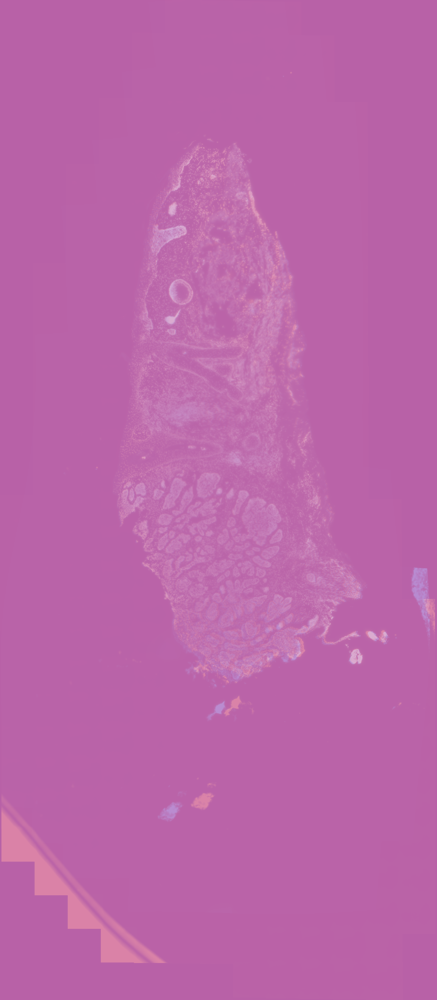

In [35]:
moving_rgb_final_2 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, final_transform)
thumbnail(show_alignment(pil_img_dapi1, moving_rgb_final_2, prefilter = True))

In [36]:
moving_resampled_2 = sitk.Resample(moving_img, fixed_img, final_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_2)))

0.471185050441432

In [37]:
register_dapi2_1 = get_pil_from_itk(moving_resampled_2)
register_dapi2_1.size

(7859, 17989)

In [38]:
print(moving_rgb_final_2.size)
change_color_mv_rgb_final_2 = np.array(moving_rgb_final_2)
print(change_color_mv_rgb_final_2.shape)
foreground = Image.fromarray(cv2.cvtColor(change_color_mv_rgb_final_2, cv2.COLOR_BGR2RGB))
background = pil_img_dapi1


(7859, 17989)
(17989, 7859, 3)


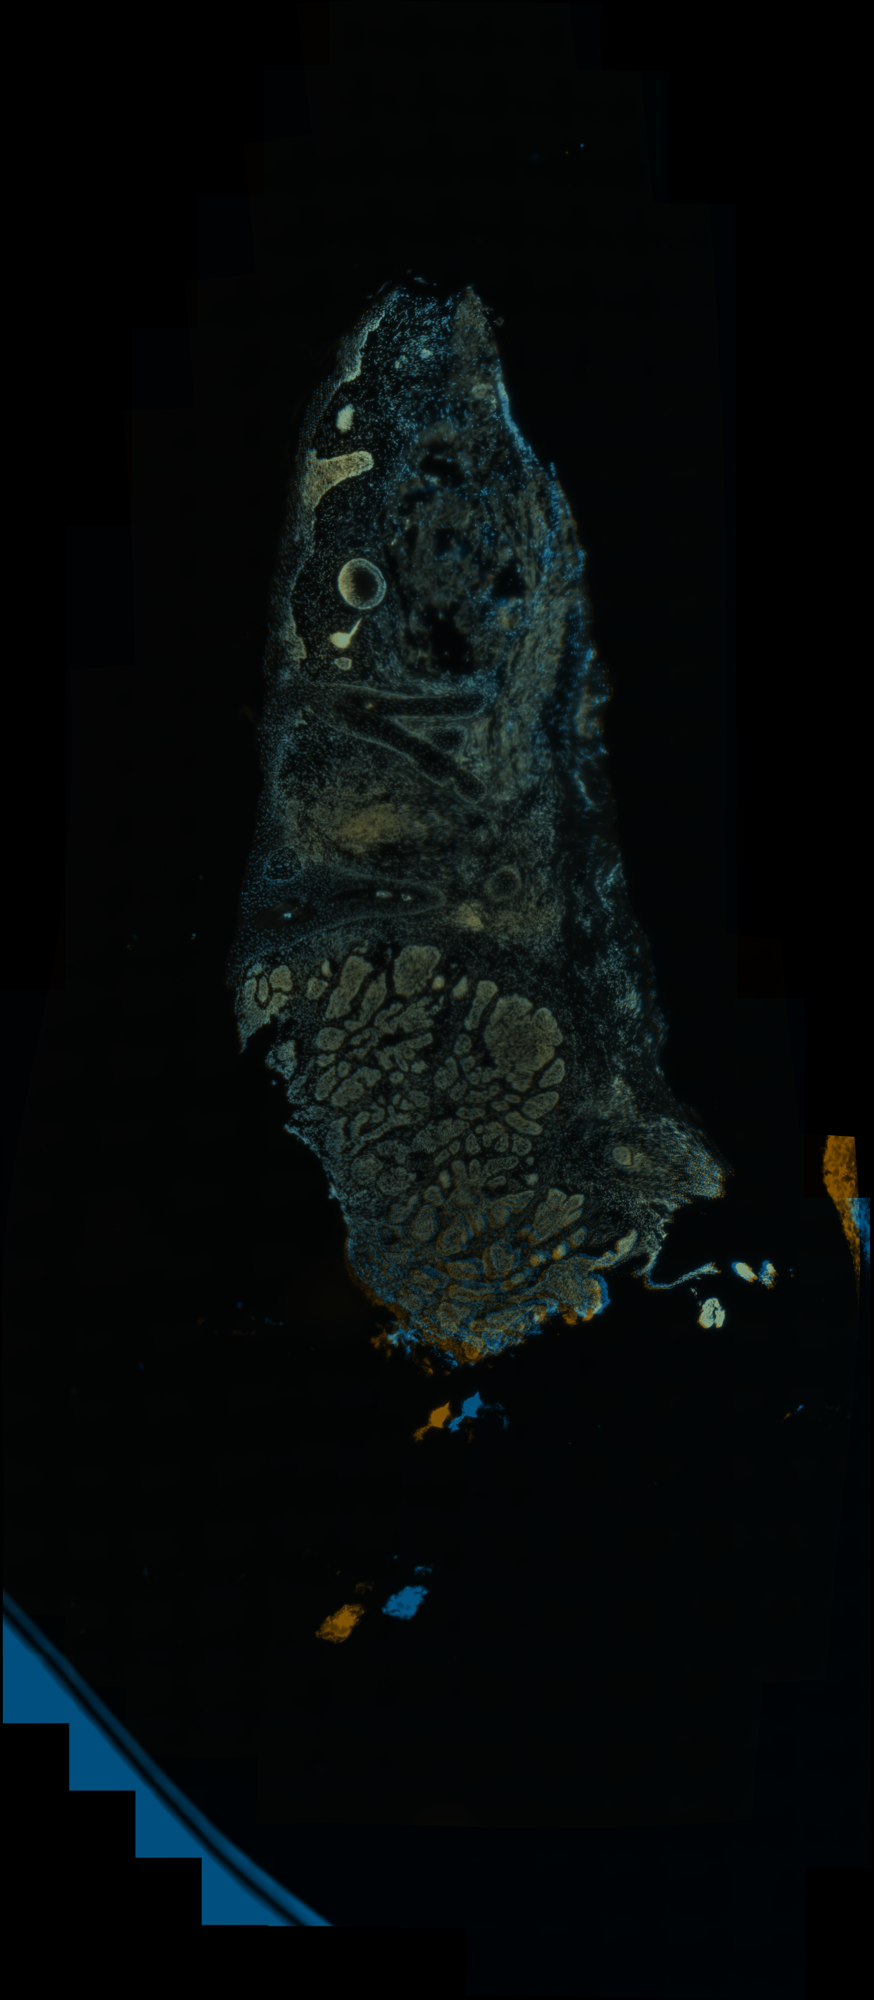

In [39]:
overlayed_imgs_2 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_2, size = (2000,2000))

### Affine + B-Spline Registration

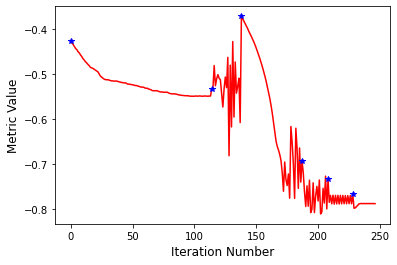

Affine metric value: -0.7870404962153748
Affine Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.


In [72]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=75)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.      
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,2,1,0])
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,3,2,1])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,3,2,1,0])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkEndEvent, end_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

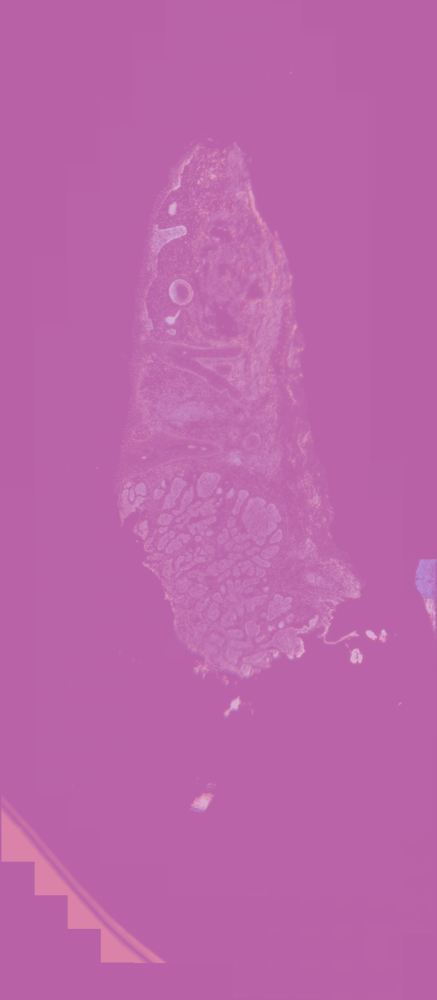

In [67]:
moving_rgb_final_3 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
thumbnail(show_alignment(pil_img_dapi1, moving_rgb_final_3, prefilter = True))

In [77]:
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_affine)))
# 0.45857039987708703
# 0.4795487076368148

0.4795487076368148

In [69]:
print(moving_rgb_final_2.size)
change_color_mv_rgb_final_3 = np.array(moving_rgb_final_3)
print(change_color_mv_rgb_final_3.shape)
foreground = Image.fromarray(cv2.cvtColor(change_color_mv_rgb_final_3, cv2.COLOR_BGR2RGB))
background = pil_img_dapi1

(7859, 17989)
(17989, 7859, 3)


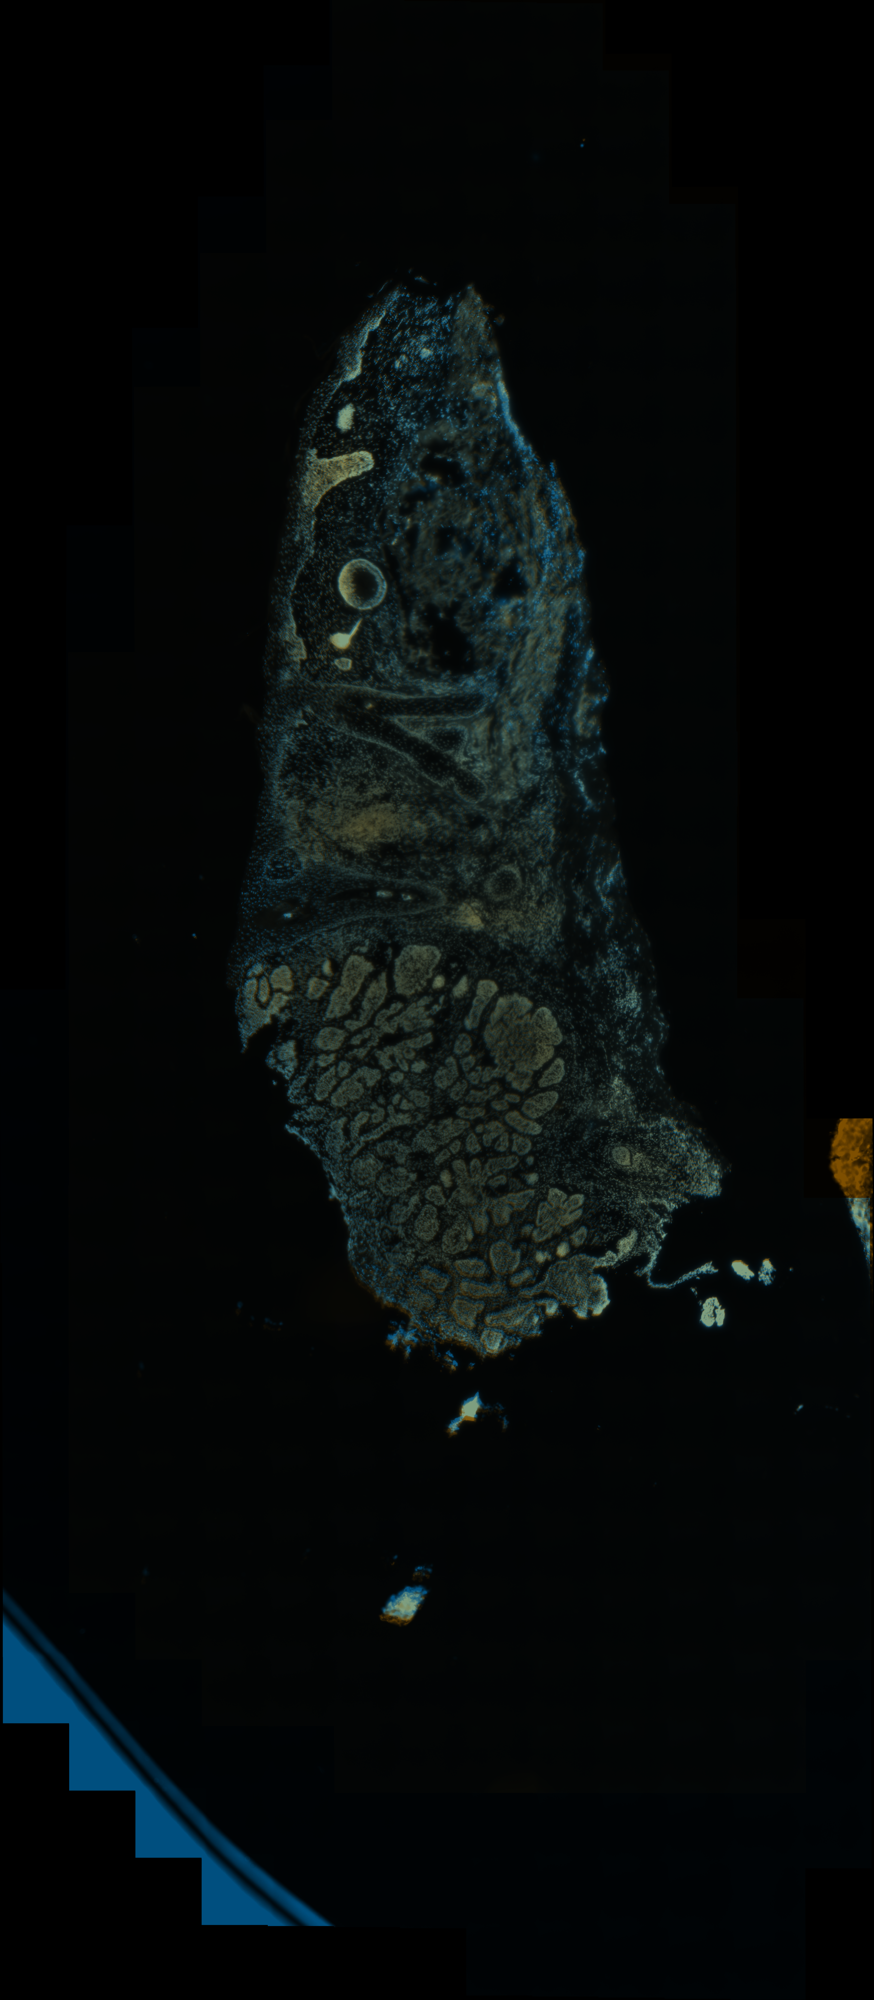

In [74]:
overlayed_imgs_3 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_3, size = (2000,2000))

In [75]:
overlayed_imgs_3=overlayed_imgs_3.convert('RGB')
overlayed_imgs_3.save('sitk_register_2.pdf')

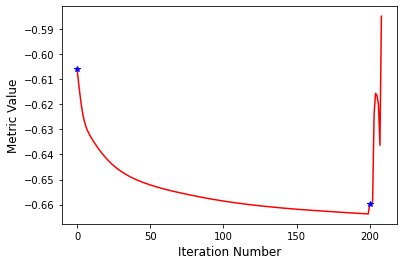

BSpline metric value: -0.6238224124132578
BSpline Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [78]:
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkEndEvent, end_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

print('BSpline metric value: {0}'.format(bspline_method.GetMetricValue()))
print('BSpline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [79]:
moving_resampled_final_4 = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_final_4)))

0.49333757671355316

In [84]:
moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
moving_rgb_final_4 = sitk_transform_rgb(moving_rgb_affine, pil_img_dapi1, bspline_transform)
# thumbnail(show_alignment(he, moving_rgb_final, prefilter = True))
# moving_rgb_final_3 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, bspline_transform)
print(moving_rgb_final_4.size)
change_color_mv_rgb_final_4 = np.array(moving_rgb_final_4)
print(change_color_mv_rgb_final_4.shape)
foreground = Image.fromarray(cv2.cvtColor(change_color_mv_rgb_final_4, cv2.COLOR_BGR2RGB))
background = pil_img_dapi1

(7859, 17989)
(17989, 7859, 3)


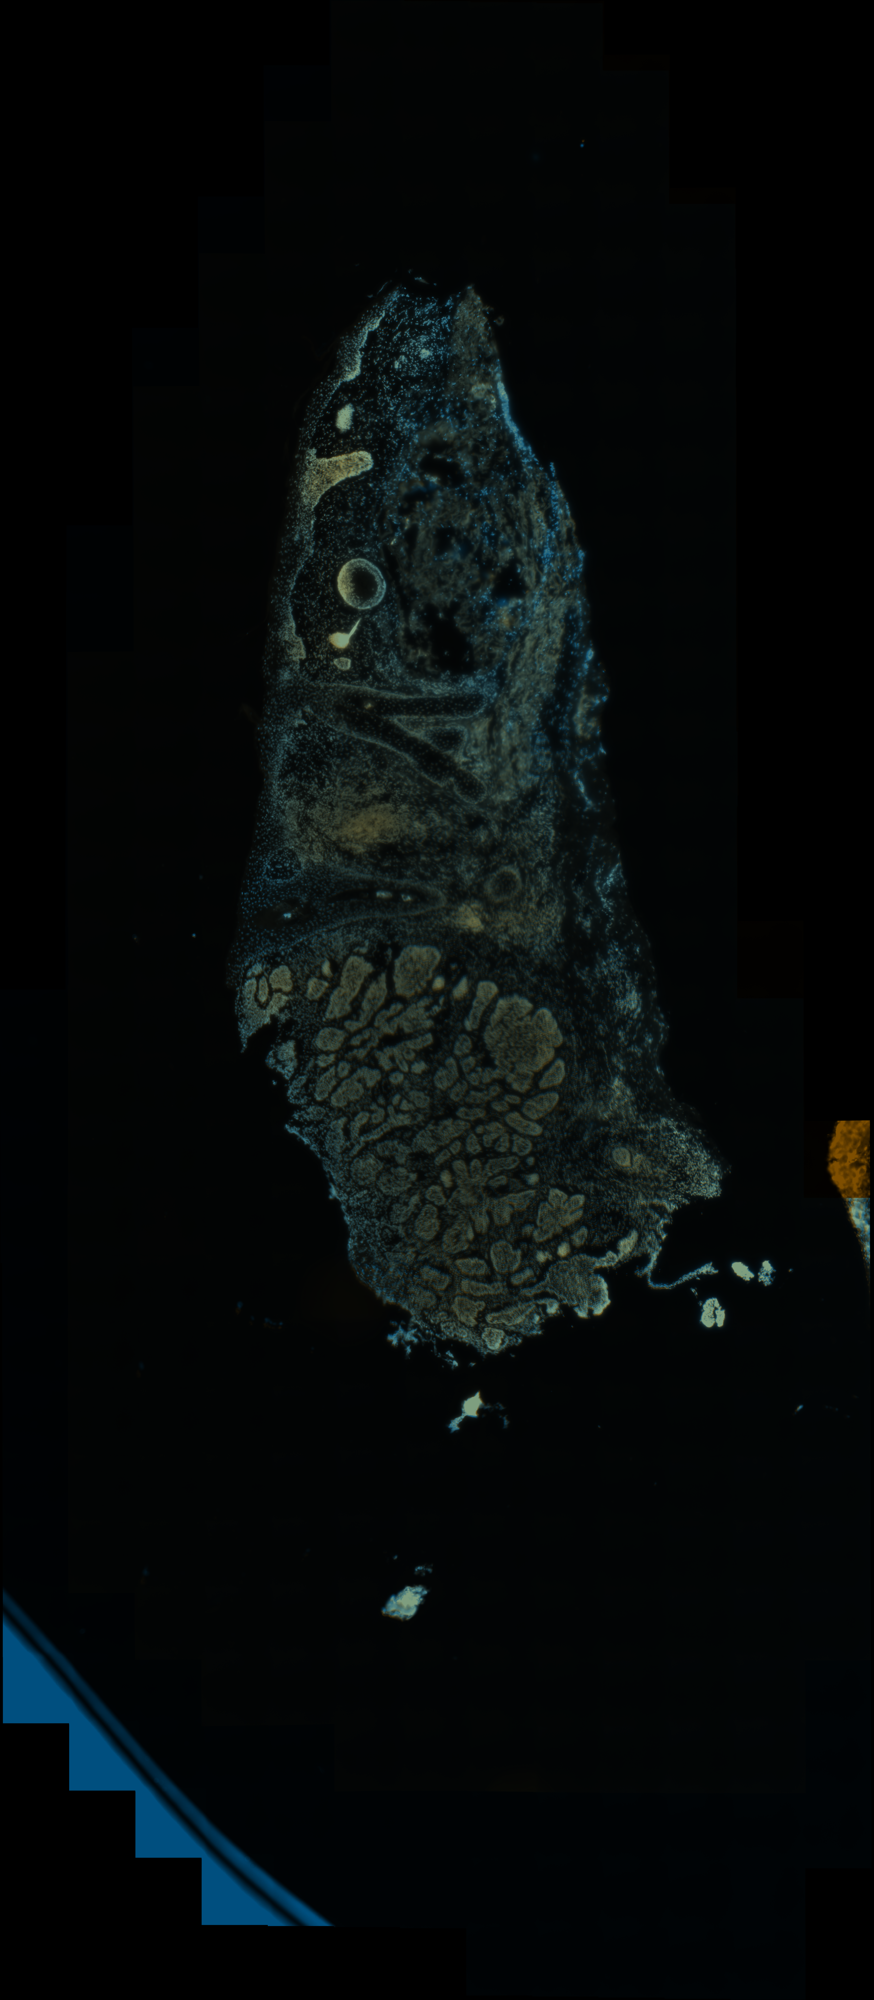

In [85]:
overlayed_imgs_4 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_4, size = (2000,2000))

In [ ]:
overlayed_imgs_1=overlayed_imgs_1.convert('RGB')
overlayed_imgs_1.save('sitk_register_1.pdf')